In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
from PyEMD import EMD
import opensmile
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [2]:
#%% Prepare the downloaded IEMOCAP dataset for SER

#Deal with the IEMOCAP metadata to gain the file paths of the improvised speeches in the four desired emotion classes
#Read the metadata about the dataset
df_descri=pd.read_csv("/Users/talen/Documents/Datasets/IEMOCAP/iemocap_metadata.csv")

#Only select the improvised samples to create a description file
# df_impro=df_descri[df_descri["method"]=="impro"]
df_impro=df_descri.copy()

#Replace the default file-path with the local file-path after downloaded in the author's computer
new_paths = []

    #Gain the old paths from "path" column of the description file
old_paths = df_impro["path"].map(str)
for old_path in old_paths:
    #Extract the file names
    path_list = str(old_path).split("/")
    file_name = path_list[-1]

    #Concatenate the filename with the local folder path and saved in new_paths variable
    new_path = "/Users/talen/Documents/Datasets/IEMOCAP/Data/" + file_name
    new_paths.append(new_path)

#Replace the old paths with the new paths in the description file
df_impro.loc[:,["path"]]=new_paths

#Select the data about the angry, happy, sad, neutral emotions from the description file
df_ang = df_impro[df_impro["emotion"]=="ang"]

df_hap = df_impro[df_impro["emotion"]=="hap"]
df_exc = df_impro[df_impro["emotion"]=="exc"]

df_sad = df_impro[df_impro["emotion"]=="sad"]
df_neu = df_impro[df_impro["emotion"]=="neu"]

# df_ang = df_descri[df_descri["emotion"]=="ang"]
# df_hap = df_descri[df_descri["emotion"]=="hap"]
# df_sad = df_descri[df_descri["emotion"]=="sad"]
# df_neu = df_descri[df_descri["emotion"]=="neu"]


#Concatenate the data of the four emotions
df_final = pd.concat([df_ang, df_hap, df_exc, df_sad, df_neu])
df_final.shape

(5531, 7)

In [3]:
print(len(df_ang), len(df_hap)+len(df_exc), len(df_neu), len(df_sad))

1103 1636 1708 1084


In [4]:
#create a variable for restoring the LLDs, smfcc, their corresponding emotion classes, 
#and the number of segments per signal
#emotion classes: ang -> 0, hap, exc -> 1, sad -> 2, neu -> 3
Audio_features = {
    "1": {
        "LLDs":[], "smfcc":[], "class":[], "n_segments_per_signal":[]
    },
    "2": {
        "LLDs":[], "smfcc":[], "class":[], "n_segments_per_signal":[]
    },
    "3": {
        "LLDs":[], "smfcc":[], "class":[], "n_segments_per_signal":[]
    },
    "4": {
        "LLDs":[], "smfcc":[], "class":[], "n_segments_per_signal":[]
    },
    "5": {
        "LLDs":[], "smfcc":[], "class":[], "n_segments_per_signal":[]
    }
}


In [5]:
#Sampling and quantising the raw audio file into the digital signal
def Sampling_and_quantising(file_path):
    audiofile = file_path

    #Sampling and quantising the audio file into digital signals with the sampling rate of 16kHz
    signal, sr = librosa.load(audiofile, sr=16000)

    return signal, sr


#Framing and windowing the audio signal with specified window-width and sliding
def Framing_signal(signal,window_width, sliding, sr):
    #Framing the signal, with specified window width and sliding
    framesize = int((window_width/1000) * sr)
    slide = int((sliding/1000) * sr)

    frames = librosa.util.frame(signal, frame_length=framesize, hop_length=slide, axis=0)

    #Create Hamming window
    window = librosa.filters.get_window(window="ham",Nx=framesize,fftbins=True)

    #Apply the window function on each frame
    windowed_frames = []
    for frame in frames:
        windowed_frame = frame*window
        windowed_frames.append(windowed_frame)

    return windowed_frames, framesize


#Create signal segments for computing the segment-level features
def Frames_to_segments(frames, n_frames_per_segment, slide):
    segments_list = []

    n_segments = int((len(frames)-n_frames_per_segment)/slide + 1)

    for s in range(n_segments):
        segment_start = s*slide
        segment_end = segment_start+n_frames_per_segment
        seg = frames[segment_start : segment_end]

        #Concatenate the frame-level coefficients in each segment
        segment_tempo = seg[0]
        for l in range(1, len(seg)):
            segment_tempo = np.concatenate((segment_tempo, seg[l]))

        segments_list.append(segment_tempo)

    segments = np.array(segments_list)

    return segments


In [6]:
#Extract the LLDs of ComParE_2016 by openSMILE, except for the mfcc-related data
def Gain_LLDs(signal, sr, session, emotion):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    LLDs = smile.process_signal(signal, sr)

    drop_criteria = ["mfcc" in x for x in LLDs.columns]

    drop_indices = []
    for index in range(len(drop_criteria)):
        if drop_criteria[index]:
            drop_indices.append(LLDs.columns[index])

    LLDs.drop(labels=drop_indices, axis=1, inplace=True)
    
    values = LLDs.values[0]
    values = values.tolist()

    return values



#Compute the Log-Mel-spectrogram
def Gain_Log_Mel_spectrogram(signal, sr, n_fft, n_mels, window, win_length, hop_length):

    #Compute the Log-Mel-Spectrogram for each segment
    #1.Compute the spectrogram for each segment by 1024 point short-time FT
    stft = librosa.core.stft(y=signal, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)
    spectrogram = np.abs(stft)

    #2.Compute the mel-spectrogram by applying the 40 mel filter banks on the spectrogram coefficient
    mel_spectrogram = librosa.feature.melspectrogram(sr=sr, S=spectrogram, n_mels=n_mels)

    #3.Compute the logarithm of the mel-spectrogram coefficient
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram


#Compute the MFCCs
def Gain_MFCCs(signal, sr, n_fft, n_mels, n_mfcc, session, emotion):
    smfccs = librosa.feature.mfcc(y=signal,sr=sr,n_mfcc=n_mfcc, dct_type=2, norm="ortho",
                         n_mels=n_mels, n_fft=n_fft)

    #Transpose the SMFCCs so as the row denotes the time
    smfccs = smfccs.T

    #Store the SMFCCs and their emotion labels under the respective path in the Audio_features dictionary
    smfccs = smfccs.tolist()

    return smfccs

In [7]:
def Extract_segment_level_features(current_row):
    global h,count1, n_segments_per_signal

    #Gain the audio file path, together with its emotion classes, and session path
    audiofile = str(current_row["path"])
    emotion = str(current_row["emotion"])
    session = str(current_row["session"])


    #Sampling and quantising the raw audio into the digital signal
    signal, sr = Sampling_and_quantising(audiofile)
    
    
#     #Channel 1: extracting features from original signal
#         #Framing and windowing, with Hamming-window of 25ms and slide of 10ms
#     frames1, _ = Framing_signal(signal=signal, window_width=25, sliding=10, sr=sr)
#         #Create segments with the size of 30 frames and 10 frames overlapping (or 20 frames sliding)
#     segments1 = Frames_to_segments(frames=frames1, n_frames_per_segment=30, slide=20)

#     for segment1 in segments1:
#         #Extract the segment-level LLDs with their functionals from the original signal by openSMILE
#         values = Gain_LLDs(signal=segment1, sr=sr, session=session, emotion=emotion)
        
#             #Restore the LLDs in the Audio_features dictionary
#         Audio_features[session]["LLDs"].append(values)

#         if emotion == "ang":
#             Audio_features[session]["class"].append(0)
#         elif emotion == "hap":
#             Audio_features[session]["class"].append(1)
#         elif emotion == "sad":
#             Audio_features[session]["class"].append(2)
#         else:
#             Audio_features[session]["class"].append(3)
    
    
    #Channel 2: extracting features from the signal with trend removed
    #Remove signal trend by Zero-crossing detection method
        #1.Use Empirical Mode Decomposition (EMD) method to decompose the signal into IMFs
    emd = EMD()
    IMFs = emd.emd(signal, max_imf=9)

        #2. Select the IMFs that satisfy particular criterion
        #2.1 Criterion analysis: ZCR_IMF_i / ZCR_IMF_1 < 0.01  =>  N_ZC_IMF_i / N_ZC_IMF_1 < 0.01, when the IMFs has the same time length
    IMFs_selected_index = []

        #2.2 The zero crossing of the first IMF
    R_imf_1 = librosa.core.zero_crossings(IMFs[0], pad=False, zero_pos=True)
    n_R_imf_1 = sum(R_imf_1)

    for i in range(1, len(IMFs)):
        R_imf_i = librosa.core.zero_crossings(IMFs[i], pad=False, zero_pos=True)
        n_R_imf_i = sum(R_imf_i)

        #2.3 Check the criterion
        if n_R_imf_i / n_R_imf_1 < 0.01:
            IMFs_selected_index.append(i)

        #3. Derive the signal trend based on the selected IMFs
    T = IMFs[0]

    for index in range(1, len(IMFs_selected_index)):
        T = T + IMFs[index]

        #4. Subtract the signal trend from the original signal
    signal_trend_removed = signal - T

    #Framing and windowing, with Hamming-window of 25ms and slide of 10ms
    frames2, framesize = Framing_signal(signal=signal_trend_removed, window_width=25, sliding=10, sr=sr)
    # print("There are {0} frames, each frame contains {1} samples".format(len(frames),framesize))

    #Create segments with the size of 30 frames and 10 frames overlapping (or 20 frames sliding)
    segments2 = Frames_to_segments(frames=frames2, n_frames_per_segment=30, slide=20)
#         #Record the lenght of segments for time-step definition of RNN
#     Audio_features[session]["n_segments_per_signal"].append(len(segments2))
    
    #Extract segment-level spectrograms and SMFCCs from the signal with trend removed
    count_segment = 1

    for segment2 in segments2:
        #Calculate the segment-level log-mel-spectrograms by 1024 point STFT and 40 mel-filter banks
        spectro = Gain_Log_Mel_spectrogram(signal=segment2, sr=sr, n_fft=1024, n_mels=40, 
                                           window=False,win_length=None,hop_length=None)
        
        #5'.Store the graphs of log-mel-spectrograms
        librosa.display.specshow(spectro, x_axis="time", y_axis="mel")
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.savefig("/Users/talen/Desktop/spectrograms_segment_IEMOCAP/"+session+"."+str(h)+"."+str(count_segment)+"."+emotion+".jpg", 
                    pad_inches=0, bbox_inches="tight")
        print("Spectrogram of segment {0} of the audio of utterance {1} in session {2} is archived!".format(count_segment,h,session))

#         #5''.Calculate the smfcc
#         smfcc = Gain_MFCCs(signal=segment2, sr=sr, n_fft=1024, n_mels=40, n_mfcc=14, session=session, emotion=emotion)
#         Audio_features[session]["smfcc"].append(smfcc)
        
        count_segment+=1

    print("Sample {} is done!".format(h))
    h+=1

  0%|          | 0/5016 [00:00<?, ?it/s]

Spectrogram of segment 1 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 12 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 13

  0%|          | 1/5016 [00:45<62:47:04, 45.07s/it]

Spectrogram of segment 34 of the audio of utterance 515 in session 3 is archived!
Spectrogram of segment 35 of the audio of utterance 515 in session 3 is archived!
Sample 515 is done!
Spectrogram of segment 1 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 516 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 516 in session 3 is archived!
Spect

  0%|          | 2/5016 [02:57<99:14:28, 71.25s/it]

Spectrogram of segment 56 of the audio of utterance 516 in session 3 is archived!
Sample 516 is done!
Spectrogram of segment 1 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 517 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 517 in session 3 is archived!
Spect

  0%|          | 3/5016 [03:08<74:09:24, 53.25s/it]

Spectrogram of segment 15 of the audio of utterance 517 in session 3 is archived!
Sample 517 is done!
Spectrogram of segment 1 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 518 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 518 in session 3 is archived!
Spect

  0%|          | 4/5016 [03:48<68:21:08, 49.10s/it]

Spectrogram of segment 21 of the audio of utterance 518 in session 3 is archived!
Sample 518 is done!
Spectrogram of segment 1 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 519 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 519 in session 3 is archived!
Spect

  0%|          | 5/5016 [04:41<70:17:59, 50.50s/it]

Spectrogram of segment 30 of the audio of utterance 519 in session 3 is archived!
Sample 519 is done!
Spectrogram of segment 1 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 520 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 520 in session 3 is archived!
Spect

  0%|          | 6/5016 [06:53<104:01:39, 74.75s/it]

Spectrogram of segment 42 of the audio of utterance 520 in session 3 is archived!
Sample 520 is done!
Spectrogram of segment 1 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 521 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 521 in session 3 is archived!
Spect

  0%|          | 7/5016 [07:27<86:59:29, 62.52s/it] 

Spectrogram of segment 27 of the audio of utterance 521 in session 3 is archived!
Sample 521 is done!
Spectrogram of segment 1 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 522 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 522 in session 3 is archived!
Spect

  0%|          | 8/5016 [07:57<73:25:10, 52.78s/it]

Spectrogram of segment 21 of the audio of utterance 522 in session 3 is archived!
Sample 522 is done!
Spectrogram of segment 1 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 523 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 523 in session 3 is archived!
Spect

  0%|          | 9/5016 [08:48<72:52:14, 52.39s/it]

Spectrogram of segment 28 of the audio of utterance 523 in session 3 is archived!
Sample 523 is done!
Spectrogram of segment 1 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 524 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 524 in session 3 is archived!
Spect

  0%|          | 10/5016 [09:08<59:21:10, 42.68s/it]

Spectrogram of segment 15 of the audio of utterance 524 in session 3 is archived!
Sample 524 is done!
Spectrogram of segment 1 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 525 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 525 in session 3 is archived!
Spect

  0%|          | 11/5016 [11:38<104:03:29, 74.85s/it]

Spectrogram of segment 49 of the audio of utterance 525 in session 3 is archived!
Sample 525 is done!
Spectrogram of segment 1 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 526 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 526 in session 3 is archived!
Spect

  0%|          | 12/5016 [16:08<185:09:36, 133.21s/it]

Spectrogram of segment 73 of the audio of utterance 526 in session 3 is archived!
Sample 526 is done!
Spectrogram of segment 1 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 527 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 527 in session 3 is archived!
Spect

  0%|          | 13/5016 [17:54<173:59:49, 125.20s/it]

Spectrogram of segment 43 of the audio of utterance 527 in session 3 is archived!
Sample 527 is done!
Spectrogram of segment 1 of the audio of utterance 528 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 528 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 528 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 528 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 528 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 528 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 528 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 528 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 528 in session 3 is archived!


  0%|          | 14/5016 [18:13<129:29:26, 93.20s/it] 

Spectrogram of segment 10 of the audio of utterance 528 in session 3 is archived!
Sample 528 is done!
Spectrogram of segment 1 of the audio of utterance 529 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 529 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 529 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 529 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 529 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 529 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 529 in session 3 is archived!


  0%|          | 15/5016 [18:27<96:44:39, 69.64s/it] 

Spectrogram of segment 8 of the audio of utterance 529 in session 3 is archived!
Sample 529 is done!
Spectrogram of segment 1 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 530 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 530 in session 3 is archived!
Spectr

  0%|          | 16/5016 [19:00<81:17:40, 58.53s/it]

Spectrogram of segment 16 of the audio of utterance 530 in session 3 is archived!
Sample 530 is done!
Spectrogram of segment 1 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 531 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 531 in session 3 is archived!
Spect

  0%|          | 17/5016 [20:33<95:49:39, 69.01s/it]

Spectrogram of segment 35 of the audio of utterance 531 in session 3 is archived!
Sample 531 is done!
Spectrogram of segment 1 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 532 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 532 in session 3 is archived!
Spect

  0%|          | 18/5016 [23:07<131:03:28, 94.40s/it]

Spectrogram of segment 44 of the audio of utterance 532 in session 3 is archived!
Sample 532 is done!
Spectrogram of segment 1 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 533 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 533 in session 3 is archived!
Spect

  0%|          | 19/5016 [23:37<104:14:32, 75.10s/it]

Spectrogram of segment 14 of the audio of utterance 533 in session 3 is archived!
Sample 533 is done!
Spectrogram of segment 1 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 534 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 534 in session 3 is archived!
Spect

  0%|          | 20/5016 [24:21<91:22:12, 65.84s/it] 

Spectrogram of segment 19 of the audio of utterance 534 in session 3 is archived!
Sample 534 is done!
Spectrogram of segment 1 of the audio of utterance 535 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 535 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 535 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 535 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 535 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 535 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 535 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 535 in session 3 is archived!


  0%|          | 21/5016 [24:42<72:23:41, 52.18s/it]

Spectrogram of segment 9 of the audio of utterance 535 in session 3 is archived!
Sample 535 is done!
Spectrogram of segment 1 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 536 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 536 in session 3 is archived!
Spectr

  0%|          | 22/5016 [25:46<77:20:32, 55.75s/it]

Spectrogram of segment 27 of the audio of utterance 536 in session 3 is archived!
Sample 536 is done!
Spectrogram of segment 1 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 537 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 537 in session 3 is archived!
Spect

  0%|          | 23/5016 [26:14<65:55:31, 47.53s/it]

Spectrogram of segment 13 of the audio of utterance 537 in session 3 is archived!
Sample 537 is done!
Spectrogram of segment 1 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 538 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 538 in session 3 is archived!
Spect

  0%|          | 24/5016 [27:18<72:42:25, 52.43s/it]

Spectrogram of segment 26 of the audio of utterance 538 in session 3 is archived!
Sample 538 is done!
Spectrogram of segment 1 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 539 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 539 in session 3 is archived!
Spect

  0%|          | 25/5016 [27:54<65:54:32, 47.54s/it]

Spectrogram of segment 15 of the audio of utterance 539 in session 3 is archived!
Sample 539 is done!
Spectrogram of segment 1 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 540 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 540 in session 3 is archived!


  1%|          | 26/5016 [28:20<56:57:52, 41.10s/it]

Spectrogram of segment 11 of the audio of utterance 540 in session 3 is archived!
Sample 540 is done!
Spectrogram of segment 1 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 541 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 541 in session 3 is archived!
Spect

  1%|          | 27/5016 [29:46<75:29:06, 54.47s/it]

Spectrogram of segment 32 of the audio of utterance 541 in session 3 is archived!
Sample 541 is done!
Spectrogram of segment 1 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 542 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 542 in session 3 is archived!
Spect

  1%|          | 28/5016 [31:13<89:03:36, 64.28s/it]

Spectrogram of segment 31 of the audio of utterance 542 in session 3 is archived!
Sample 542 is done!
Spectrogram of segment 1 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 543 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 543 in session 3 is archived!
Spect

  1%|          | 29/5016 [33:22<115:56:50, 83.70s/it]

Spectrogram of segment 36 of the audio of utterance 543 in session 3 is archived!
Sample 543 is done!
Spectrogram of segment 1 of the audio of utterance 544 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 544 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 544 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 544 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 544 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 544 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 544 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 544 in session 3 is archived!


  1%|          | 30/5016 [33:47<91:24:48, 66.00s/it] 

Spectrogram of segment 9 of the audio of utterance 544 in session 3 is archived!
Sample 544 is done!
Spectrogram of segment 1 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 545 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 545 in session 3 is archived!
Spectr

  1%|          | 31/5016 [34:44<88:00:00, 63.55s/it]

Spectrogram of segment 21 of the audio of utterance 545 in session 3 is archived!
Sample 545 is done!
Spectrogram of segment 1 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 546 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 546 in session 3 is archived!
Spect

  1%|          | 32/5016 [36:43<110:48:43, 80.04s/it]

Spectrogram of segment 29 of the audio of utterance 546 in session 3 is archived!
Sample 546 is done!
Spectrogram of segment 1 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 547 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 547 in session 3 is archived!
Spect

  1%|          | 33/5016 [37:55<107:38:56, 77.77s/it]

Spectrogram of segment 23 of the audio of utterance 547 in session 3 is archived!
Sample 547 is done!
Spectrogram of segment 1 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 548 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 548 in session 3 is archived!
Spect

  1%|          | 34/5016 [39:16<108:46:11, 78.60s/it]

Spectrogram of segment 24 of the audio of utterance 548 in session 3 is archived!
Sample 548 is done!
Spectrogram of segment 1 of the audio of utterance 549 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 549 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 549 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 549 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 549 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 549 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 549 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 549 in session 3 is archived!


  1%|          | 35/5016 [39:43<87:10:41, 63.01s/it] 

Spectrogram of segment 9 of the audio of utterance 549 in session 3 is archived!
Sample 549 is done!
Spectrogram of segment 1 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 550 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 550 in session 3 is archived!
Spectr

  1%|          | 36/5016 [40:59<92:55:21, 67.17s/it]

Spectrogram of segment 24 of the audio of utterance 550 in session 3 is archived!
Sample 550 is done!
Spectrogram of segment 1 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 551 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 551 in session 3 is archived!
Spect

  1%|          | 37/5016 [41:39<81:37:22, 59.02s/it]

Spectrogram of segment 13 of the audio of utterance 551 in session 3 is archived!
Sample 551 is done!
Spectrogram of segment 1 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 552 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 552 in session 3 is archived!
Spect

  1%|          | 38/5016 [42:27<76:53:45, 55.61s/it]

Spectrogram of segment 15 of the audio of utterance 552 in session 3 is archived!
Sample 552 is done!
Spectrogram of segment 1 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 553 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 553 in session 3 is archived!
Spect

  1%|          | 39/5016 [43:39<83:32:34, 60.43s/it]

Spectrogram of segment 22 of the audio of utterance 553 in session 3 is archived!
Sample 553 is done!
Spectrogram of segment 1 of the audio of utterance 554 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 554 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 554 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 554 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 554 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 554 in session 3 is archived!


  1%|          | 40/5016 [44:02<67:56:08, 49.15s/it]

Spectrogram of segment 7 of the audio of utterance 554 in session 3 is archived!
Sample 554 is done!
Spectrogram of segment 1 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 555 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 555 in session 3 is archived!
Spectr

  1%|          | 41/5016 [44:59<71:17:56, 51.59s/it]

Spectrogram of segment 17 of the audio of utterance 555 in session 3 is archived!
Sample 555 is done!
Spectrogram of segment 1 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 556 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 556 in session 3 is archived!
Spect

  1%|          | 42/5016 [46:09<78:56:40, 57.14s/it]

Spectrogram of segment 20 of the audio of utterance 556 in session 3 is archived!
Sample 556 is done!
Spectrogram of segment 1 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 557 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 557 in session 3 is archived!
Spect

  1%|          | 43/5016 [48:50<121:49:14, 88.19s/it]

Spectrogram of segment 37 of the audio of utterance 557 in session 3 is archived!
Sample 557 is done!
Spectrogram of segment 1 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 558 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 558 in session 3 is archived!
Spect

  1%|          | 44/5016 [49:40<105:58:42, 76.73s/it]

Spectrogram of segment 13 of the audio of utterance 558 in session 3 is archived!
Sample 558 is done!
Spectrogram of segment 1 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 559 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 559 in session 3 is archived!
Spect

  1%|          | 45/5016 [51:32<120:45:09, 87.45s/it]

Spectrogram of segment 24 of the audio of utterance 559 in session 3 is archived!
Sample 559 is done!
Spectrogram of segment 1 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 560 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 560 in session 3 is archived!
Spect

  1%|          | 46/5016 [52:54<118:19:20, 85.71s/it]

Spectrogram of segment 21 of the audio of utterance 560 in session 3 is archived!
Sample 560 is done!
Spectrogram of segment 1 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 561 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 561 in session 3 is archived!
Spect

  1%|          | 47/5016 [55:45<153:45:56, 111.40s/it]

Spectrogram of segment 38 of the audio of utterance 561 in session 3 is archived!
Sample 561 is done!
Spectrogram of segment 1 of the audio of utterance 562 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 562 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 562 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 562 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 562 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 562 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 562 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 562 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 562 in session 3 is archived!


  1%|          | 48/5016 [56:23<123:10:03, 89.25s/it] 

Spectrogram of segment 10 of the audio of utterance 562 in session 3 is archived!
Sample 562 is done!
Spectrogram of segment 1 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 563 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 563 in session 3 is archived!
Spect

  1%|          | 49/5016 [59:52<172:41:12, 125.16s/it]

Spectrogram of segment 43 of the audio of utterance 563 in session 3 is archived!
Sample 563 is done!
Spectrogram of segment 1 of the audio of utterance 564 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 564 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 564 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 564 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 564 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 564 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 564 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 564 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 564 in session 3 is archived!


  1%|          | 50/5016 [1:00:34<138:27:19, 100.37s/it]

Spectrogram of segment 10 of the audio of utterance 564 in session 3 is archived!
Sample 564 is done!
Spectrogram of segment 1 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 565 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 565 in session 3 is archived!
Spect

  1%|          | 51/5016 [1:01:59<131:55:03, 95.65s/it] 

Spectrogram of segment 20 of the audio of utterance 565 in session 3 is archived!
Sample 565 is done!
Spectrogram of segment 1 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 566 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 566 in session 3 is archived!
Spect

  1%|          | 52/5016 [1:03:40<134:06:51, 97.26s/it]

Spectrogram of segment 23 of the audio of utterance 566 in session 3 is archived!
Sample 566 is done!
Spectrogram of segment 1 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 567 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 567 in session 3 is archived!
Spect

  1%|          | 53/5016 [1:06:05<154:06:19, 111.78s/it]

Spectrogram of segment 33 of the audio of utterance 567 in session 3 is archived!
Sample 567 is done!
Spectrogram of segment 1 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 568 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 568 in session 3 is archived!
Spect

  1%|          | 54/5016 [1:10:03<205:58:39, 149.44s/it]

Spectrogram of segment 43 of the audio of utterance 568 in session 3 is archived!
Sample 568 is done!
Spectrogram of segment 1 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 569 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 569 in session 3 is archived!
Spect

  1%|          | 55/5016 [1:16:44<309:50:58, 224.85s/it]

Spectrogram of segment 67 of the audio of utterance 569 in session 3 is archived!
Sample 569 is done!
Spectrogram of segment 1 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 570 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 570 in session 3 is archived!
Spect

  1%|          | 56/5016 [1:17:49<243:44:03, 176.90s/it]

Spectrogram of segment 14 of the audio of utterance 570 in session 3 is archived!
Sample 570 is done!
Spectrogram of segment 1 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 571 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 571 in session 3 is archived!
Spect

  1%|          | 57/5016 [1:23:16<305:43:53, 221.95s/it]

Spectrogram of segment 59 of the audio of utterance 571 in session 3 is archived!
Sample 571 is done!
Spectrogram of segment 1 of the audio of utterance 572 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 572 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 572 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 572 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 572 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 572 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 572 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 572 in session 3 is archived!


  1%|          | 58/5016 [1:23:59<231:58:36, 168.44s/it]

Spectrogram of segment 9 of the audio of utterance 572 in session 3 is archived!
Sample 572 is done!
Spectrogram of segment 1 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 573 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 573 in session 3 is archived!
Spectr

  1%|          | 59/5016 [1:26:35<226:42:40, 164.65s/it]

Spectrogram of segment 28 of the audio of utterance 573 in session 3 is archived!
Sample 573 is done!
Spectrogram of segment 1 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 574 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 574 in session 3 is archived!
Spect

  1%|          | 60/5016 [1:28:07<196:47:29, 142.95s/it]

Spectrogram of segment 19 of the audio of utterance 574 in session 3 is archived!
Sample 574 is done!
Spectrogram of segment 1 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 575 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 575 in session 3 is archived!
Spect

  1%|          | 61/5016 [1:36:08<336:01:41, 244.14s/it]

Spectrogram of segment 71 of the audio of utterance 575 in session 3 is archived!
Sample 575 is done!
Spectrogram of segment 1 of the audio of utterance 576 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 576 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 576 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 576 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 576 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 576 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 576 in session 3 is archived!


  1%|          | 62/5016 [1:36:47<251:27:43, 182.73s/it]

Spectrogram of segment 8 of the audio of utterance 576 in session 3 is archived!
Sample 576 is done!
Spectrogram of segment 1 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 577 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 577 in session 3 is archived!
Spectr

  1%|▏         | 63/5016 [1:40:14<261:14:48, 189.88s/it]

Spectrogram of segment 34 of the audio of utterance 577 in session 3 is archived!
Sample 577 is done!
Spectrogram of segment 1 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 578 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 578 in session 3 is archived!
Spect

  1%|▏         | 64/5016 [1:43:33<264:55:10, 192.59s/it]

Spectrogram of segment 33 of the audio of utterance 578 in session 3 is archived!
Sample 578 is done!
Spectrogram of segment 1 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 579 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 579 in session 3 is archived!
Spect

  1%|▏         | 65/5016 [1:45:24<231:17:16, 168.18s/it]

Spectrogram of segment 21 of the audio of utterance 579 in session 3 is archived!
Sample 579 is done!
Spectrogram of segment 1 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 580 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 580 in session 3 is archived!
Spect

  1%|▏         | 66/5016 [1:46:33<190:30:29, 138.55s/it]

Spectrogram of segment 13 of the audio of utterance 580 in session 3 is archived!
Sample 580 is done!
Spectrogram of segment 1 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 581 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 581 in session 3 is archived!
Spect

  1%|▏         | 67/5016 [1:48:11<173:34:32, 126.26s/it]

Spectrogram of segment 18 of the audio of utterance 581 in session 3 is archived!
Sample 581 is done!
Spectrogram of segment 1 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 582 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 582 in session 3 is archived!
Spect

  1%|▏         | 68/5016 [1:49:55<164:32:55, 119.72s/it]

Spectrogram of segment 19 of the audio of utterance 582 in session 3 is archived!
Sample 582 is done!
Spectrogram of segment 1 of the audio of utterance 583 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 583 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 583 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 583 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 583 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 583 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 583 in session 3 is archived!


  1%|▏         | 69/5016 [1:50:38<132:53:07, 96.70s/it] 

Spectrogram of segment 8 of the audio of utterance 583 in session 3 is archived!
Sample 583 is done!
Spectrogram of segment 1 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 584 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 584 in session 3 is archived!


  1%|▏         | 70/5016 [1:51:38<117:33:49, 85.57s/it]

Spectrogram of segment 11 of the audio of utterance 584 in session 3 is archived!
Sample 584 is done!
Spectrogram of segment 1 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 585 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 585 in session 3 is archived!
Spect

  1%|▏         | 71/5016 [1:53:34<130:16:43, 94.84s/it]

Spectrogram of segment 20 of the audio of utterance 585 in session 3 is archived!
Sample 585 is done!
Spectrogram of segment 1 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 586 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 586 in session 3 is archived!
Spect

  1%|▏         | 72/5016 [1:56:06<153:31:50, 111.79s/it]

Spectrogram of segment 24 of the audio of utterance 586 in session 3 is archived!
Sample 586 is done!
Spectrogram of segment 1 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 587 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 587 in session 3 is archived!
Spect

  1%|▏         | 73/5016 [1:57:19<137:48:56, 100.37s/it]

Spectrogram of segment 13 of the audio of utterance 587 in session 3 is archived!
Sample 587 is done!
Spectrogram of segment 1 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 588 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 588 in session 3 is archived!
Spect

  1%|▏         | 74/5016 [1:59:32<150:58:48, 109.98s/it]

Spectrogram of segment 23 of the audio of utterance 588 in session 3 is archived!
Sample 588 is done!
Spectrogram of segment 1 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 589 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 589 in session 3 is archived!


  1%|▏         | 75/5016 [2:00:37<132:36:45, 96.62s/it] 

Spectrogram of segment 11 of the audio of utterance 589 in session 3 is archived!
Sample 589 is done!
Spectrogram of segment 1 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 590 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 590 in session 3 is archived!
Spect

  2%|▏         | 76/5016 [2:05:22<210:09:40, 153.15s/it]

Spectrogram of segment 44 of the audio of utterance 590 in session 3 is archived!
Sample 590 is done!
Spectrogram of segment 1 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 591 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 591 in session 3 is archived!
Spect

  2%|▏         | 77/5016 [2:08:22<220:55:01, 161.02s/it]

Spectrogram of segment 27 of the audio of utterance 591 in session 3 is archived!
Sample 591 is done!
Spectrogram of segment 1 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 592 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 592 in session 3 is archived!
Spect

  2%|▏         | 78/5016 [2:12:37<259:34:50, 189.24s/it]

Spectrogram of segment 40 of the audio of utterance 592 in session 3 is archived!
Sample 592 is done!
Spectrogram of segment 1 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 593 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 593 in session 3 is archived!
Spect

  2%|▏         | 79/5016 [2:14:09<219:45:11, 160.24s/it]

Spectrogram of segment 15 of the audio of utterance 593 in session 3 is archived!
Sample 593 is done!
Spectrogram of segment 1 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 594 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 594 in session 3 is archived!
Spect

  2%|▏         | 80/5016 [2:16:30<211:32:06, 154.28s/it]

Spectrogram of segment 23 of the audio of utterance 594 in session 3 is archived!
Sample 594 is done!
Spectrogram of segment 1 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 595 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 595 in session 3 is archived!
Spect

  2%|▏         | 81/5016 [2:19:59<234:11:57, 170.84s/it]

Spectrogram of segment 32 of the audio of utterance 595 in session 3 is archived!
Sample 595 is done!
Spectrogram of segment 1 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 596 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 596 in session 3 is archived!
Spect

  2%|▏         | 82/5016 [2:21:39<205:07:56, 149.67s/it]

Spectrogram of segment 16 of the audio of utterance 596 in session 3 is archived!
Sample 596 is done!
Spectrogram of segment 1 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 597 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 597 in session 3 is archived!
Spect

  2%|▏         | 83/5016 [2:23:34<190:36:39, 139.10s/it]

Spectrogram of segment 18 of the audio of utterance 597 in session 3 is archived!
Sample 597 is done!
Spectrogram of segment 1 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 598 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 598 in session 3 is archived!
Spect

  2%|▏         | 84/5016 [2:26:51<214:33:56, 156.62s/it]

Spectrogram of segment 27 of the audio of utterance 598 in session 3 is archived!
Sample 598 is done!
Spectrogram of segment 1 of the audio of utterance 599 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 599 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 599 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 599 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 599 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 599 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 599 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 599 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 599 in session 3 is archived!


  2%|▏         | 85/5016 [2:27:56<176:33:04, 128.90s/it]

Spectrogram of segment 10 of the audio of utterance 599 in session 3 is archived!
Sample 599 is done!
Spectrogram of segment 1 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 600 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 600 in session 3 is archived!
Spect

  2%|▏         | 86/5016 [2:30:22<183:48:07, 134.22s/it]

Spectrogram of segment 22 of the audio of utterance 600 in session 3 is archived!
Sample 600 is done!
Spectrogram of segment 1 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 601 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 601 in session 3 is archived!
Spect

  2%|▏         | 87/5016 [2:31:47<163:22:50, 119.33s/it]

Spectrogram of segment 13 of the audio of utterance 601 in session 3 is archived!
Sample 601 is done!
Spectrogram of segment 1 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 602 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 602 in session 3 is archived!
Spect

  2%|▏         | 88/5016 [2:33:27<155:39:27, 113.71s/it]

Spectrogram of segment 15 of the audio of utterance 602 in session 3 is archived!
Sample 602 is done!
Spectrogram of segment 1 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 603 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 603 in session 3 is archived!
Spect

  2%|▏         | 89/5016 [2:38:19<228:50:09, 167.20s/it]

Spectrogram of segment 40 of the audio of utterance 603 in session 3 is archived!
Sample 603 is done!
Spectrogram of segment 1 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 604 in session 3 is archived!
Spectrogram of segment 11 of the audio of utterance 604 in session 3 is archived!
Spect

  2%|▏         | 90/5016 [2:39:52<198:21:29, 144.96s/it]

Spectrogram of segment 14 of the audio of utterance 604 in session 3 is archived!
Sample 604 is done!
Spectrogram of segment 1 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 2 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 3 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 4 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 5 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 6 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 7 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 8 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 9 of the audio of utterance 605 in session 3 is archived!
Spectrogram of segment 10 of the audio of utterance 605 in session 3 is archived!


  2%|▏         | 91/5016 [2:41:06<169:09:21, 123.65s/it]

Spectrogram of segment 11 of the audio of utterance 605 in session 3 is archived!
Sample 605 is done!
Spectrogram of segment 1 of the audio of utterance 606 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 606 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 606 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 606 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 606 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 606 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 606 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 606 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 606 in session 4 is archived!


  2%|▏         | 92/5016 [2:42:16<147:08:47, 107.58s/it]

Spectrogram of segment 10 of the audio of utterance 606 in session 4 is archived!
Sample 606 is done!
Spectrogram of segment 1 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 607 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 607 in session 4 is archived!
Spect

  2%|▏         | 93/5016 [2:43:47<140:04:06, 102.43s/it]

Spectrogram of segment 13 of the audio of utterance 607 in session 4 is archived!
Sample 607 is done!
Spectrogram of segment 1 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 608 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 608 in session 4 is archived!
Spect

  2%|▏         | 94/5016 [2:49:09<229:58:13, 168.20s/it]

Spectrogram of segment 40 of the audio of utterance 608 in session 4 is archived!
Sample 608 is done!
Spectrogram of segment 1 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 609 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 609 in session 4 is archived!
Spect

  2%|▏         | 95/5016 [2:50:51<203:05:16, 148.57s/it]

Spectrogram of segment 14 of the audio of utterance 609 in session 4 is archived!
Sample 609 is done!
Spectrogram of segment 1 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 610 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 610 in session 4 is archived!
Spect

  2%|▏         | 96/5016 [2:53:19<202:30:40, 148.18s/it]

Spectrogram of segment 20 of the audio of utterance 610 in session 4 is archived!
Sample 610 is done!
Spectrogram of segment 1 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 611 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 611 in session 4 is archived!
Spect

  2%|▏         | 97/5016 [2:56:04<209:39:11, 153.44s/it]

Spectrogram of segment 22 of the audio of utterance 611 in session 4 is archived!
Sample 611 is done!
Spectrogram of segment 1 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 612 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 612 in session 4 is archived!


  2%|▏         | 98/5016 [2:57:33<182:59:21, 133.95s/it]

Spectrogram of segment 12 of the audio of utterance 612 in session 4 is archived!
Sample 612 is done!
Spectrogram of segment 1 of the audio of utterance 613 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 613 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 613 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 613 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 613 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 613 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 613 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 613 in session 4 is archived!


  2%|▏         | 99/5016 [2:58:38<154:41:56, 113.26s/it]

Spectrogram of segment 9 of the audio of utterance 613 in session 4 is archived!
Sample 613 is done!
Spectrogram of segment 1 of the audio of utterance 614 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 614 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 614 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 614 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 614 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 614 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 614 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 614 in session 4 is archived!


  2%|▏         | 100/5016 [2:59:42<134:44:31, 98.67s/it]

Spectrogram of segment 9 of the audio of utterance 614 in session 4 is archived!
Sample 614 is done!
Spectrogram of segment 1 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 615 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 615 in session 4 is archived!
Spectr

  2%|▏         | 101/5016 [3:01:25<136:17:10, 99.82s/it]

Spectrogram of segment 14 of the audio of utterance 615 in session 4 is archived!
Sample 615 is done!
Spectrogram of segment 1 of the audio of utterance 616 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 616 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 616 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 616 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 616 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 616 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 616 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 616 in session 4 is archived!


  2%|▏         | 102/5016 [3:02:30<121:58:41, 89.36s/it]

Spectrogram of segment 9 of the audio of utterance 616 in session 4 is archived!
Sample 616 is done!
Spectrogram of segment 1 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 617 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 617 in session 4 is archived!
Spectr

  2%|▏         | 103/5016 [3:04:21<130:44:39, 95.80s/it]

Spectrogram of segment 15 of the audio of utterance 617 in session 4 is archived!
Sample 617 is done!
Spectrogram of segment 1 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 618 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 618 in session 4 is archived!
Spect

  2%|▏         | 104/5016 [3:10:59<254:41:45, 186.67s/it]

Spectrogram of segment 45 of the audio of utterance 618 in session 4 is archived!
Sample 618 is done!
Spectrogram of segment 1 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 619 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 619 in session 4 is archived!


  2%|▏         | 105/5016 [3:12:30<215:24:26, 157.90s/it]

Spectrogram of segment 12 of the audio of utterance 619 in session 4 is archived!
Sample 619 is done!
Spectrogram of segment 1 of the audio of utterance 620 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 620 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 620 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 620 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 620 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 620 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 620 in session 4 is archived!


  2%|▏         | 106/5016 [3:13:28<174:27:41, 127.91s/it]

Spectrogram of segment 8 of the audio of utterance 620 in session 4 is archived!
Sample 620 is done!
Spectrogram of segment 1 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 621 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 621 in session 4 is archived!
Spectr

  2%|▏         | 107/5016 [3:16:02<185:11:06, 135.80s/it]

Spectrogram of segment 20 of the audio of utterance 621 in session 4 is archived!
Sample 621 is done!
Spectrogram of segment 1 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 622 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 622 in session 4 is archived!
Spect

  2%|▏         | 108/5016 [3:18:18<185:00:40, 135.70s/it]

Spectrogram of segment 18 of the audio of utterance 622 in session 4 is archived!
Sample 622 is done!
Spectrogram of segment 1 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 623 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 623 in session 4 is archived!
Spect

  2%|▏         | 109/5016 [3:25:12<299:00:47, 219.37s/it]

Spectrogram of segment 47 of the audio of utterance 623 in session 4 is archived!
Sample 623 is done!
Spectrogram of segment 1 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 624 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 624 in session 4 is archived!
Spect

  2%|▏         | 110/5016 [3:27:31<265:45:08, 195.01s/it]

Spectrogram of segment 18 of the audio of utterance 624 in session 4 is archived!
Sample 624 is done!
Spectrogram of segment 1 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 625 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 625 in session 4 is archived!
Spect

  2%|▏         | 111/5016 [3:32:25<306:11:06, 224.72s/it]

Spectrogram of segment 37 of the audio of utterance 625 in session 4 is archived!
Sample 625 is done!
Spectrogram of segment 1 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 626 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 626 in session 4 is archived!
Spect

  2%|▏         | 112/5016 [3:34:29<265:17:02, 194.74s/it]

Spectrogram of segment 16 of the audio of utterance 626 in session 4 is archived!
Sample 626 is done!
Spectrogram of segment 1 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 627 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 627 in session 4 is archived!
Spect

  2%|▏         | 113/5016 [3:36:52<243:59:30, 179.15s/it]

Spectrogram of segment 18 of the audio of utterance 627 in session 4 is archived!
Sample 627 is done!
Spectrogram of segment 1 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 628 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 628 in session 4 is archived!
Spect

  2%|▏         | 114/5016 [3:39:19<230:35:26, 169.34s/it]

Spectrogram of segment 18 of the audio of utterance 628 in session 4 is archived!
Sample 628 is done!
Spectrogram of segment 1 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 629 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 629 in session 4 is archived!
Spect

  2%|▏         | 115/5016 [3:41:01<203:09:18, 149.23s/it]

Spectrogram of segment 13 of the audio of utterance 629 in session 4 is archived!
Sample 629 is done!
Spectrogram of segment 1 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 630 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 630 in session 4 is archived!


  2%|▏         | 116/5016 [3:42:28<177:33:23, 130.45s/it]

Spectrogram of segment 11 of the audio of utterance 630 in session 4 is archived!
Sample 630 is done!
Spectrogram of segment 1 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 631 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 631 in session 4 is archived!
Spect

  2%|▏         | 117/5016 [3:44:25<172:08:30, 126.50s/it]

Spectrogram of segment 14 of the audio of utterance 631 in session 4 is archived!
Sample 631 is done!
Spectrogram of segment 1 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 632 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 632 in session 4 is archived!
Spect

  2%|▏         | 118/5016 [3:46:44<177:27:25, 130.43s/it]

Spectrogram of segment 17 of the audio of utterance 632 in session 4 is archived!
Sample 632 is done!
Spectrogram of segment 1 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 633 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 633 in session 4 is archived!
Spect

  2%|▏         | 119/5016 [3:52:19<260:52:59, 191.79s/it]

Spectrogram of segment 37 of the audio of utterance 633 in session 4 is archived!
Sample 633 is done!
Spectrogram of segment 1 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 634 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 634 in session 4 is archived!
Spect

  2%|▏         | 120/5016 [3:58:08<324:44:53, 238.79s/it]

Spectrogram of segment 39 of the audio of utterance 634 in session 4 is archived!
Sample 634 is done!
Spectrogram of segment 1 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 635 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 635 in session 4 is archived!
Spect

  2%|▏         | 121/5016 [4:02:36<336:45:52, 247.67s/it]

Spectrogram of segment 31 of the audio of utterance 635 in session 4 is archived!
Sample 635 is done!
Spectrogram of segment 1 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 636 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 636 in session 4 is archived!
Spect

  2%|▏         | 122/5016 [4:09:36<406:59:40, 299.38s/it]

Spectrogram of segment 44 of the audio of utterance 636 in session 4 is archived!
Sample 636 is done!
Spectrogram of segment 1 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 637 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 637 in session 4 is archived!
Spect

  2%|▏         | 123/5016 [4:11:55<341:15:00, 251.07s/it]

Spectrogram of segment 16 of the audio of utterance 637 in session 4 is archived!
Sample 637 is done!
Spectrogram of segment 1 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 638 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 638 in session 4 is archived!
Spect

  2%|▏         | 124/5016 [4:15:38<330:03:54, 242.89s/it]

Spectrogram of segment 26 of the audio of utterance 638 in session 4 is archived!
Sample 638 is done!
Spectrogram of segment 1 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 639 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 639 in session 4 is archived!
Spect

  2%|▏         | 125/5016 [4:22:01<386:52:55, 284.76s/it]

Spectrogram of segment 40 of the audio of utterance 639 in session 4 is archived!
Sample 639 is done!
Spectrogram of segment 1 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 640 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 640 in session 4 is archived!
Spect

  3%|▎         | 126/5016 [4:24:32<332:12:04, 244.57s/it]

Spectrogram of segment 17 of the audio of utterance 640 in session 4 is archived!
Sample 640 is done!
Spectrogram of segment 1 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 641 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 641 in session 4 is archived!
Spect

  3%|▎         | 127/5016 [4:26:35<282:55:33, 208.33s/it]

Spectrogram of segment 14 of the audio of utterance 641 in session 4 is archived!
Sample 641 is done!
Spectrogram of segment 1 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 642 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 642 in session 4 is archived!
Spect

  3%|▎         | 128/5016 [4:31:08<309:04:42, 227.64s/it]

Spectrogram of segment 28 of the audio of utterance 642 in session 4 is archived!
Sample 642 is done!
Spectrogram of segment 1 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 643 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 643 in session 4 is archived!


  3%|▎         | 129/5016 [4:32:45<255:47:40, 188.43s/it]

Spectrogram of segment 11 of the audio of utterance 643 in session 4 is archived!
Sample 643 is done!
Spectrogram of segment 1 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 644 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 644 in session 4 is archived!
Spect

  3%|▎         | 130/5016 [4:39:35<345:44:52, 254.75s/it]

Spectrogram of segment 42 of the audio of utterance 644 in session 4 is archived!
Sample 644 is done!
Spectrogram of segment 1 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 645 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 645 in session 4 is archived!
Spect

  3%|▎         | 131/5016 [4:44:12<355:06:14, 261.69s/it]

Spectrogram of segment 30 of the audio of utterance 645 in session 4 is archived!
Sample 645 is done!
Spectrogram of segment 1 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 646 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 646 in session 4 is archived!
Spect

  3%|▎         | 132/5016 [4:54:30<499:56:28, 368.51s/it]

Spectrogram of segment 57 of the audio of utterance 646 in session 4 is archived!
Sample 646 is done!
Spectrogram of segment 1 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 647 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 647 in session 4 is archived!
Spect

  3%|▎         | 133/5016 [4:59:35<473:50:07, 349.34s/it]

Spectrogram of segment 32 of the audio of utterance 647 in session 4 is archived!
Sample 647 is done!
Spectrogram of segment 1 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 648 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 648 in session 4 is archived!
Spect

  3%|▎         | 134/5016 [5:02:26<401:05:01, 295.76s/it]

Spectrogram of segment 18 of the audio of utterance 648 in session 4 is archived!
Sample 648 is done!
Spectrogram of segment 1 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 649 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 649 in session 4 is archived!
Spect

  3%|▎         | 135/5016 [5:04:28<330:41:48, 243.91s/it]

Spectrogram of segment 13 of the audio of utterance 649 in session 4 is archived!
Sample 649 is done!
Spectrogram of segment 1 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 650 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 650 in session 4 is archived!
Spect

  3%|▎         | 136/5016 [5:10:44<384:13:16, 283.44s/it]

Spectrogram of segment 36 of the audio of utterance 650 in session 4 is archived!
Sample 650 is done!
Spectrogram of segment 1 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 651 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 651 in session 4 is archived!
Spect

  3%|▎         | 137/5016 [5:12:57<322:52:55, 238.24s/it]

Spectrogram of segment 14 of the audio of utterance 651 in session 4 is archived!
Sample 651 is done!
Spectrogram of segment 1 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 652 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 652 in session 4 is archived!
Spect

  3%|▎         | 138/5016 [5:18:11<353:34:20, 260.94s/it]

Spectrogram of segment 32 of the audio of utterance 652 in session 4 is archived!
Sample 652 is done!
Spectrogram of segment 1 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 653 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 653 in session 4 is archived!
Spect

  3%|▎         | 139/5016 [5:21:16<322:43:10, 238.22s/it]

Spectrogram of segment 19 of the audio of utterance 653 in session 4 is archived!
Sample 653 is done!
Spectrogram of segment 1 of the audio of utterance 654 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 654 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 654 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 654 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 654 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 654 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 654 in session 4 is archived!


  3%|▎         | 140/5016 [5:22:33<257:03:40, 189.79s/it]

Spectrogram of segment 8 of the audio of utterance 654 in session 4 is archived!
Sample 654 is done!
Spectrogram of segment 1 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 655 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 655 in session 4 is archived!


  3%|▎         | 141/5016 [5:24:18<222:29:40, 164.30s/it]

Spectrogram of segment 11 of the audio of utterance 655 in session 4 is archived!
Sample 655 is done!
Spectrogram of segment 1 of the audio of utterance 656 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 656 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 656 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 656 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 656 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 656 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 656 in session 4 is archived!


  3%|▎         | 142/5016 [5:25:35<187:15:15, 138.31s/it]

Spectrogram of segment 8 of the audio of utterance 656 in session 4 is archived!
Sample 656 is done!
Spectrogram of segment 1 of the audio of utterance 657 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 657 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 657 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 657 in session 4 is archived!


  3%|▎         | 143/5016 [5:26:23<150:27:23, 111.15s/it]

Spectrogram of segment 5 of the audio of utterance 657 in session 4 is archived!
Sample 657 is done!
Spectrogram of segment 1 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 658 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 658 in session 4 is archived!
Spectr

  3%|▎         | 144/5016 [5:29:02<169:51:20, 125.51s/it]

Spectrogram of segment 16 of the audio of utterance 658 in session 4 is archived!
Sample 658 is done!
Spectrogram of segment 1 of the audio of utterance 659 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 659 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 659 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 659 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 659 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 659 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 659 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 659 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 659 in session 4 is archived!


  3%|▎         | 145/5016 [5:30:39<158:15:19, 116.96s/it]

Spectrogram of segment 10 of the audio of utterance 659 in session 4 is archived!
Sample 659 is done!
Spectrogram of segment 1 of the audio of utterance 660 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 660 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 660 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 660 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 660 in session 4 is archived!


  3%|▎         | 146/5016 [5:31:37<134:07:54, 99.15s/it] 

Spectrogram of segment 6 of the audio of utterance 660 in session 4 is archived!
Sample 660 is done!
Spectrogram of segment 1 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 661 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 661 in session 4 is archived!
Spectr

  3%|▎         | 147/5016 [5:36:51<221:20:24, 163.65s/it]

Spectrogram of segment 31 of the audio of utterance 661 in session 4 is archived!
Sample 661 is done!
Spectrogram of segment 1 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 662 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 662 in session 4 is archived!


  3%|▎         | 148/5016 [5:38:52<203:57:08, 150.83s/it]

Spectrogram of segment 12 of the audio of utterance 662 in session 4 is archived!
Sample 662 is done!
Spectrogram of segment 1 of the audio of utterance 663 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 663 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 663 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 663 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 663 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 663 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 663 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 663 in session 4 is archived!


  3%|▎         | 149/5016 [5:40:22<179:13:58, 132.57s/it]

Spectrogram of segment 9 of the audio of utterance 663 in session 4 is archived!
Sample 663 is done!
Spectrogram of segment 1 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 664 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 664 in session 4 is archived!
Spectr

  3%|▎         | 150/5016 [5:43:32<202:33:17, 149.86s/it]

Spectrogram of segment 19 of the audio of utterance 664 in session 4 is archived!
Sample 664 is done!
Spectrogram of segment 1 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 665 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 665 in session 4 is archived!
Spect

  3%|▎         | 151/5016 [5:45:54<199:24:42, 147.56s/it]

Spectrogram of segment 14 of the audio of utterance 665 in session 4 is archived!
Sample 665 is done!
Spectrogram of segment 1 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 666 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 666 in session 4 is archived!
Spect

  3%|▎         | 152/5016 [5:50:11<243:38:29, 180.33s/it]

Spectrogram of segment 25 of the audio of utterance 666 in session 4 is archived!
Sample 666 is done!
Spectrogram of segment 1 of the audio of utterance 667 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 667 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 667 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 667 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 667 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 667 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 667 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 667 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 667 in session 4 is archived!


  3%|▎         | 153/5016 [5:51:52<211:37:20, 156.66s/it]

Spectrogram of segment 10 of the audio of utterance 667 in session 4 is archived!
Sample 667 is done!
Spectrogram of segment 1 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 668 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 668 in session 4 is archived!
Spect

  3%|▎         | 154/5016 [5:54:58<223:08:07, 165.22s/it]

Spectrogram of segment 18 of the audio of utterance 668 in session 4 is archived!
Sample 668 is done!
Spectrogram of segment 1 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 669 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 669 in session 4 is archived!
Spect

  3%|▎         | 155/5016 [5:57:12<210:38:00, 155.99s/it]

Spectrogram of segment 13 of the audio of utterance 669 in session 4 is archived!
Sample 669 is done!
Spectrogram of segment 1 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 670 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 670 in session 4 is archived!
Spect

  3%|▎         | 156/5016 [5:59:45<209:15:04, 155.00s/it]

Spectrogram of segment 15 of the audio of utterance 670 in session 4 is archived!
Sample 670 is done!
Spectrogram of segment 1 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 671 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 671 in session 4 is archived!
Spect

  3%|▎         | 157/5016 [6:02:32<214:09:10, 158.66s/it]

Spectrogram of segment 16 of the audio of utterance 671 in session 4 is archived!
Sample 671 is done!
Spectrogram of segment 1 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 672 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 672 in session 4 is archived!
Spect

  3%|▎         | 158/5016 [6:05:15<215:46:19, 159.90s/it]

Spectrogram of segment 16 of the audio of utterance 672 in session 4 is archived!
Sample 672 is done!
Spectrogram of segment 1 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 673 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 673 in session 4 is archived!
Spect

  3%|▎         | 159/5016 [6:07:49<213:20:24, 158.13s/it]

Spectrogram of segment 15 of the audio of utterance 673 in session 4 is archived!
Sample 673 is done!
Spectrogram of segment 1 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 674 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 674 in session 4 is archived!
Spect

  3%|▎         | 160/5016 [6:12:35<265:07:58, 196.56s/it]

Spectrogram of segment 27 of the audio of utterance 674 in session 4 is archived!
Sample 674 is done!
Spectrogram of segment 1 of the audio of utterance 675 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 675 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 675 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 675 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 675 in session 4 is archived!


  3%|▎         | 161/5016 [6:13:37<210:46:39, 156.29s/it]

Spectrogram of segment 6 of the audio of utterance 675 in session 4 is archived!
Sample 675 is done!
Spectrogram of segment 1 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 676 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 676 in session 4 is archived!
Spectr

  3%|▎         | 162/5016 [6:18:53<275:15:06, 204.14s/it]

Spectrogram of segment 29 of the audio of utterance 676 in session 4 is archived!
Sample 676 is done!
Spectrogram of segment 1 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 677 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 677 in session 4 is archived!


  3%|▎         | 163/5016 [6:21:02<244:38:20, 181.48s/it]

Spectrogram of segment 12 of the audio of utterance 677 in session 4 is archived!
Sample 677 is done!
Spectrogram of segment 1 of the audio of utterance 678 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 678 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 678 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 678 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 678 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 678 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 678 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 678 in session 4 is archived!


  3%|▎         | 164/5016 [6:22:35<209:03:47, 155.12s/it]

Spectrogram of segment 9 of the audio of utterance 678 in session 4 is archived!
Sample 678 is done!
Spectrogram of segment 1 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 679 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 679 in session 4 is archived!
Spectr

  3%|▎         | 165/5016 [6:24:52<201:36:00, 149.61s/it]

Spectrogram of segment 13 of the audio of utterance 679 in session 4 is archived!
Sample 679 is done!
Spectrogram of segment 1 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 680 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 680 in session 4 is archived!
Spect

  3%|▎         | 166/5016 [6:30:40<281:53:36, 209.24s/it]

Spectrogram of segment 32 of the audio of utterance 680 in session 4 is archived!
Sample 680 is done!
Spectrogram of segment 1 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 681 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 681 in session 4 is archived!
Spect

  3%|▎         | 167/5016 [6:35:38<317:23:39, 235.64s/it]

Spectrogram of segment 27 of the audio of utterance 681 in session 4 is archived!
Sample 681 is done!
Spectrogram of segment 1 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 682 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 682 in session 4 is archived!
Spect

  3%|▎         | 168/5016 [6:39:27<314:54:40, 233.85s/it]

Spectrogram of segment 20 of the audio of utterance 682 in session 4 is archived!
Sample 682 is done!
Spectrogram of segment 1 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 683 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 683 in session 4 is archived!
Spect

  3%|▎         | 169/5016 [6:42:13<287:17:59, 213.39s/it]

Spectrogram of segment 15 of the audio of utterance 683 in session 4 is archived!
Sample 683 is done!
Spectrogram of segment 1 of the audio of utterance 684 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 684 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 684 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 684 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 684 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 684 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 684 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 684 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 684 in session 4 is archived!


  3%|▎         | 170/5016 [6:44:02<245:07:55, 182.10s/it]

Spectrogram of segment 10 of the audio of utterance 684 in session 4 is archived!
Sample 684 is done!
Spectrogram of segment 1 of the audio of utterance 685 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 685 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 685 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 685 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 685 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 685 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 685 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 685 in session 4 is archived!


  3%|▎         | 171/5016 [6:45:39<210:45:38, 156.60s/it]

Spectrogram of segment 9 of the audio of utterance 685 in session 4 is archived!
Sample 685 is done!
Spectrogram of segment 1 of the audio of utterance 686 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 686 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 686 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 686 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 686 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 686 in session 4 is archived!


  3%|▎         | 172/5016 [6:46:55<178:14:05, 132.46s/it]

Spectrogram of segment 7 of the audio of utterance 686 in session 4 is archived!
Sample 686 is done!
Spectrogram of segment 1 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 687 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 687 in session 4 is archived!


  3%|▎         | 173/5016 [6:48:55<173:11:59, 128.75s/it]

Spectrogram of segment 11 of the audio of utterance 687 in session 4 is archived!
Sample 687 is done!
Spectrogram of segment 1 of the audio of utterance 688 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 688 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 688 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 688 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 688 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 688 in session 4 is archived!


  3%|▎         | 174/5016 [6:50:11<151:55:11, 112.95s/it]

Spectrogram of segment 7 of the audio of utterance 688 in session 4 is archived!
Sample 688 is done!
Spectrogram of segment 1 of the audio of utterance 689 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 689 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 689 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 689 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 689 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 689 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 689 in session 4 is archived!


  3%|▎         | 175/5016 [6:51:38<141:17:56, 105.08s/it]

Spectrogram of segment 8 of the audio of utterance 689 in session 4 is archived!
Sample 689 is done!
Spectrogram of segment 1 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 690 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 690 in session 4 is archived!
Spectr

  4%|▎         | 176/5016 [6:54:36<170:43:09, 126.98s/it]

Spectrogram of segment 16 of the audio of utterance 690 in session 4 is archived!
Sample 690 is done!
Spectrogram of segment 1 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 691 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 691 in session 4 is archived!


  4%|▎         | 177/5016 [6:56:40<169:25:31, 126.04s/it]

Spectrogram of segment 11 of the audio of utterance 691 in session 4 is archived!
Sample 691 is done!
Spectrogram of segment 1 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 692 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 692 in session 4 is archived!
Spect

  4%|▎         | 178/5016 [6:59:48<194:19:30, 144.60s/it]

Spectrogram of segment 17 of the audio of utterance 692 in session 4 is archived!
Sample 692 is done!
Spectrogram of segment 1 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 693 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 693 in session 4 is archived!


  4%|▎         | 179/5016 [7:01:50<185:11:56, 137.84s/it]

Spectrogram of segment 11 of the audio of utterance 693 in session 4 is archived!
Sample 693 is done!
Spectrogram of segment 1 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 694 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 694 in session 4 is archived!
Spect

  4%|▎         | 180/5016 [7:04:42<198:53:27, 148.06s/it]

Spectrogram of segment 15 of the audio of utterance 694 in session 4 is archived!
Sample 694 is done!
Spectrogram of segment 1 of the audio of utterance 695 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 695 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 695 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 695 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 695 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 695 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 695 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 695 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 695 in session 4 is archived!


  4%|▎         | 181/5016 [7:06:33<183:43:59, 136.80s/it]

Spectrogram of segment 10 of the audio of utterance 695 in session 4 is archived!
Sample 695 is done!
Spectrogram of segment 1 of the audio of utterance 696 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 696 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 696 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 696 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 696 in session 4 is archived!


  4%|▎         | 182/5016 [7:07:39<155:29:33, 115.80s/it]

Spectrogram of segment 6 of the audio of utterance 696 in session 4 is archived!
Sample 696 is done!
Spectrogram of segment 1 of the audio of utterance 697 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 697 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 697 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 697 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 697 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 697 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 697 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 697 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 697 in session 4 is archived!


  4%|▎         | 183/5016 [7:09:32<154:05:34, 114.78s/it]

Spectrogram of segment 10 of the audio of utterance 697 in session 4 is archived!
Sample 697 is done!
Spectrogram of segment 1 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 698 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 698 in session 4 is archived!
Spect

  4%|▎         | 184/5016 [7:15:50<260:20:02, 193.96s/it]

Spectrogram of segment 32 of the audio of utterance 698 in session 4 is archived!
Sample 698 is done!
Spectrogram of segment 1 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 699 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 699 in session 4 is archived!
Spect

  4%|▎         | 185/5016 [7:18:17<241:04:46, 179.65s/it]

Spectrogram of segment 13 of the audio of utterance 699 in session 4 is archived!
Sample 699 is done!
Spectrogram of segment 1 of the audio of utterance 700 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 700 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 700 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 700 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 700 in session 4 is archived!


  4%|▎         | 186/5016 [7:19:24<195:48:44, 145.95s/it]

Spectrogram of segment 6 of the audio of utterance 700 in session 4 is archived!
Sample 700 is done!
Spectrogram of segment 1 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 701 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 701 in session 4 is archived!
Spectr

  4%|▎         | 187/5016 [7:23:49<243:48:08, 181.75s/it]

Spectrogram of segment 23 of the audio of utterance 701 in session 4 is archived!
Sample 701 is done!
Spectrogram of segment 1 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 702 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 702 in session 4 is archived!
Spect

  4%|▎         | 188/5016 [7:30:55<341:59:11, 255.00s/it]

Spectrogram of segment 36 of the audio of utterance 702 in session 4 is archived!
Sample 702 is done!
Spectrogram of segment 1 of the audio of utterance 703 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 703 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 703 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 703 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 703 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 703 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 703 in session 4 is archived!


  4%|▍         | 189/5016 [7:32:27<276:24:41, 206.15s/it]

Spectrogram of segment 8 of the audio of utterance 703 in session 4 is archived!
Sample 703 is done!
Spectrogram of segment 1 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 704 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 704 in session 4 is archived!


  4%|▍         | 190/5016 [7:34:36<245:05:58, 182.83s/it]

Spectrogram of segment 11 of the audio of utterance 704 in session 4 is archived!
Sample 704 is done!
Spectrogram of segment 1 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 705 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 705 in session 4 is archived!
Spect

  4%|▍         | 191/5016 [7:37:38<244:52:25, 182.70s/it]

Spectrogram of segment 15 of the audio of utterance 705 in session 4 is archived!
Sample 705 is done!
Spectrogram of segment 1 of the audio of utterance 706 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 706 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 706 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 706 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 706 in session 4 is archived!


  4%|▍         | 192/5016 [7:38:48<199:28:44, 148.86s/it]

Spectrogram of segment 6 of the audio of utterance 706 in session 4 is archived!
Sample 706 is done!
Spectrogram of segment 1 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 707 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 707 in session 4 is archived!
Spectr

  4%|▍         | 193/5016 [7:44:01<265:32:22, 198.20s/it]

Spectrogram of segment 26 of the audio of utterance 707 in session 4 is archived!
Sample 707 is done!
Spectrogram of segment 1 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 7 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 8 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 9 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 10 of the audio of utterance 708 in session 4 is archived!
Spectrogram of segment 11 of the audio of utterance 708 in session 4 is archived!
Spect

  4%|▍         | 194/5016 [7:50:33<343:22:15, 256.35s/it]

Spectrogram of segment 31 of the audio of utterance 708 in session 4 is archived!
Sample 708 is done!
Spectrogram of segment 1 of the audio of utterance 709 in session 4 is archived!
Spectrogram of segment 2 of the audio of utterance 709 in session 4 is archived!
Spectrogram of segment 3 of the audio of utterance 709 in session 4 is archived!
Spectrogram of segment 4 of the audio of utterance 709 in session 4 is archived!
Spectrogram of segment 5 of the audio of utterance 709 in session 4 is archived!
Spectrogram of segment 6 of the audio of utterance 709 in session 4 is archived!


  4%|▍         | 195/5016 [7:52:00<275:01:34, 205.37s/it]

Spectrogram of segment 7 of the audio of utterance 709 in session 4 is archived!
Sample 709 is done!


  4%|▍         | 195/5016 [7:52:05<194:31:23, 145.26s/it]


KeyboardInterrupt: 

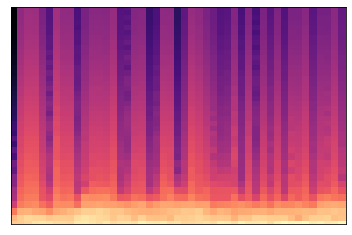

In [8]:
# Iterate all the speech samples
    #Spectrogram start from 710
h=710

for r in tqdm(range(710, len(df_final))):
    row = df_final.iloc[r,:]
    Extract_segment_level_features(row)

    
# #Store the Audio_features file locally
# data_path = "/Users/talen/Desktop/Audio_features_seg_IEMOCAP.json"

# with open(data_path, "w") as fp:
#     json.dump(Audio_features, fp, indent=4)

In [ ]:
len(Audio_features["2"]["LLDs"])

In [ ]:
type(Audio_features["5"]["Log-Mel-spectram"][-1])

In [ ]:
#Store the Audio_features file locally
data_path = "/Users/talen/Desktop/Audio_features.json"

with open(data_path, "w") as fp:
    json.dump(Audio_features, fp, indent=4)
print("Done!!!")